**Instituto Tecnológico de Aeronáutica – ITA**

**Inteligência Artificial para Robótica Móvel – CT-213**

**Professores:**

Marcos Ricardo Omena de Albuquerque Maximo

André Oliveira Françani


# Laboratório 7 – *Imitation Learning* com Keras

# 1.	Introdução

Nesse laboratório, seu objetivo é copiar um movimento de caminhar de um robô humanoide usando uma técnica chamada imitation learning. Para isso, você usará o framework de Deep Learning Keras. A Figura 1 mostra uma comparação entre o movimento da junta do quadril de arfagem obtida através de “observação” da caminhada de um robô humanoide e o mesmo movimento conforme “copiado” por uma rede neural.


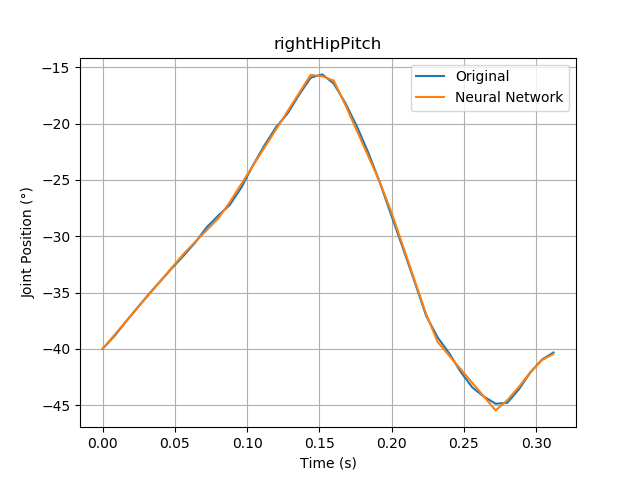

**Figura 1**: imitação do movimento da junta do quadril de arfagem através de uma rede neural.


# 2. Descrição do Problema

O problema a ser resolvido nesse laboratório é copiar o movimento de caminhar de um robô humanoide usando uma técnica chamada *imitation learning*. Nessa técnica, copia-se uma política de controle usando aprendizado supervisionado. Para a implementação da rede neural, você utilizará o *framework* Keras, que facilita o uso do *framework* Tensorflow.

O exemplo de treinamento consiste nas posições angulares das 20 juntas do robô durante um ciclo de caminhada, que foram obtidas através da “observação” das juntas do robô enquanto ele caminhava. O algoritmo de caminhada original é baseado em teoria de Controle. A entrada da rede é o tempo dentro do ciclo de caminhada (apenas 1 entrada), enquanto a saída consiste nas posições das 20 juntas. Sugere-se que a rede a ser implementada deve seguir a arquitetura apresentada na Tabela 1.


| **Layer** | **Neurons** | **Activation Function** |
|--------------|------------------|------------------------------|
| *Dense*        | 75               | *Leaky* ReLU ($\alpha=0.01$)   |
| *Dense*        | 50               | *Leaky* ReLU ($\alpha=0.01$)   |
| *Dense*        | 20               | *Linear*                       |

<p align="center">
<b>Tabela 1</b>: arquitetura da rede neural usada para o <i>imitation learning</i>. </p>


# 3.	Código Base

O código base já implementa um exemplo para familiarização com o Keras. Então, você deve implementar a rede neural usada para o *imitation learning* seguindo mais ou menos as mesmas ideias (há dicas no final do roteiro para te ajudar caso ainda tenha dificuldades).


# 4. Tarefas

Comece rodando a célula abaixo para fazer o *download* da base de dados e do arquivo utils.py com funções utilitárias.

In [ ]:
import zipfile
import os

# download data (MUST RUN)
!gdown --id 1RUdMNaioXsOhTw9nO5Mdju6wxzODytcu

with zipfile.ZipFile("lab7_ct213_2022.zip","r") as zip_ref:
  zip_ref.extractall() # extracts in current directory

# make results folder to save images
if not os.path.exists('results'):
  os.makedirs('results')

os.remove("lab7_ct213_2022.zip")

## 4.1. Estudo de Implementação de Rede Neural com Keras

Primeiramente, estude a implementação na célula abaixo para aprender como implementar uma rede neural com Keras. Sim, o Keras é muito fácil de usar! Isso que fez essa *framework* ser tão popular.

## 4.2. Análise do Efeito de Regularização

Na mesma célula abaixo, a variável ``lambda_l2`` representa o parâmetro $\lambda$ da regularização $L_2$. Treine as redes para as duas funções de classificação diferentes (*sum_gt_zero* e *xor*) e considerando $\lambda=0$ (sem regularização) e $\lambda=0.002$. Compare os resultados obtidos e discuta o efeito da regularização. Coloque os gráficos gerados no seu relatório.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import sum_gt_zero, xor
from tensorflow.keras import models, layers, losses, optimizers, activations, metrics, regularizers
import os

# Comment this line to enable training using your GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

lambda_l2 = 0.000  # lambda parameter of the L2 regularization
# lambda_l2 = 0.002  # lambda parameter of the L2 regularization
num_cases = 200  # number of auto-generated cases
num_epochs = 5000  # number of epochs for training
classification_function = sum_gt_zero  # selects sum_gt_zero as the classification function
# classification_function = xor  # selects xor as the classification function
# Figure format used for saving figures
fig_format = 'png'
# fig_format = 'svg'
# fig_format = 'eps'

if classification_function == sum_gt_zero:
    function_name = 'sgz'
else:
    function_name = 'xor'

# Setting the random seed of numpy's random library for reproducibility reasons
np.random.seed(0)

# Creating the dataset
inputs = 10.0 * (-1.0 + 2.0 * np.random.rand(num_cases, 2))
expected_outputs = np.array([classification_function(x) for x in inputs])
inputs += 2.0 * (-1.0 + 2.0 * np.random.rand(num_cases, 2))  # adding noise to corrupt the dataset

# Separating the dataset into positive and negative samples
positives_array = inputs[expected_outputs >= 0.5, :]
negatives_array = inputs[expected_outputs < 0.5, :]

# Creates the neural network model in Keras
model = models.Sequential()

# Adds the first layer
# The first argument refers to the number of neurons in this layer
# 'activation' configures the activation function
# input_shape represents the size of the input
# kernel_regularizer configures regularization for this layer
model.add(layers.Dense(50, activation=activations.sigmoid, input_shape=(2,),
                       kernel_regularizer=regularizers.l2(lambda_l2)))
model.add(layers.Dense(1, activation=activations.sigmoid, kernel_regularizer=regularizers.l2(lambda_l2)))

model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history = model.fit(inputs, expected_outputs, batch_size=(num_cases // 4), epochs=num_epochs)

# Plotting cost function convergence
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.grid()
plt.savefig('results/convergence_' + function_name + '_l' + str(lambda_l2) + '.' + fig_format, format=fig_format)

# Plotting positive and negative samples
plt.figure()
plt.plot(positives_array[:, 0], positives_array[:, 1], '+r')
plt.plot(negatives_array[:, 0], negatives_array[:, 1], 'x')
plt.xlim([-10.0, 10.0])
plt.ylim([-10.0, 10.0])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Dataset')
plt.savefig('results/dataset_' + function_name + '_l' + str(lambda_l2) + '.' + fig_format, format=fig_format)

# Plotting the decision regions of the neural network
plt.figure()
x = np.arange(-10.0, 10.05, 0.05)
y = np.arange(-10.0, 10.05, 0.05)
X, Y = np.meshgrid(x, y)
x = np.reshape(X, (np.size(X, 0) * np.size(X, 1), 1))
y = np.reshape(Y, (np.size(Y, 0) * np.size(Y, 1), 1))
input = np.concatenate((x, y), axis=1)
z = model.predict(input)
Z = z.reshape((np.size(X, 0), np.size(Y, 0)))
plt.contourf(X, Y, Z)
plt.xlim([-10.0, 10.0])
plt.ylim([-10.0, 10.0])
plt.plot(positives_array[:, 0], positives_array[:, 1], '+', color='tab:orange')
plt.plot(negatives_array[:, 0], negatives_array[:, 1], 'x')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Neural Network Classification')
plt.savefig('results/nn_classification_' + function_name + '_l' + str(lambda_l2) + '.' + fig_format, format=fig_format)

## 4.3. *Imitation Learning*

Usando Keras, implemente uma rede neural de acordo com a arquitetura apresentada na Tabela 1. Leve em consideração o seguinte para o treinamento:

- Não use regularização.
- Use todo o *dataset* em cada iteração do treinamento.
- Use erro quadrático como *loss*.
- Coloque os gráficos gerados no seu relatório e discuta os resultados.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, optimizers, activations, regularizers
from math import pi

# Joints' order in the dataset
joints_dict = dict()
joints_dict['leftAnklePitch'] = 0
joints_dict['leftAnkleRoll'] = 1
joints_dict['leftElbowYaw'] = 2
joints_dict['leftHipPitch'] = 3
joints_dict['leftHipRoll'] = 4
joints_dict['leftHipYaw'] = 5
joints_dict['leftKneePitch'] = 6
joints_dict['leftShoulderPitch'] = 7
joints_dict['leftShoulderRoll'] = 8
joints_dict['neckPitch'] = 9
joints_dict['neckYaw'] = 10
joints_dict['rightAnklePitch'] = 11
joints_dict['rightAnkleRoll'] = 12
joints_dict['rightElbowYaw'] = 13
joints_dict['rightHipPitch'] = 14
joints_dict['rightHipRoll'] = 15
joints_dict['rightHipYaw'] = 16
joints_dict['rightKneePitch'] = 17
joints_dict['rightShoulderPitch'] = 18
joints_dict['rightShoulderRoll'] = 19

right_leg_joints = ['rightHipRoll', 'rightHipPitch', 'rightKneePitch', 'rightAnklePitch', 'rightAnkleRoll']

num_epochs = 30000  # number of epochs for training
# Figure format used for saving figures
fig_format = 'png'
# fig_format = 'svg'
# fig_format = 'eps'

# Loading the dataset
positions = np.loadtxt('positions.txt')
# The dataset contains the walking cycles, but we will use only the first one for training
expected_output = positions[0:40, :]
# Creating a input vector (0.008 ms is the sample time of the walking algorithm)
input = 0.008 * np.arange(0, expected_output.shape[0])

# Setting the random seed of numpy's random library for reproducibility reasons
np.random.seed(0)

$\color{red}{\textbf{Implemente aqui a rede neural usando Keras}}$

❗ ❗ descomente a linha ```output = model.predict(input_predict)``` e remova a outra conforme comentário no código.

In [ ]:
# Todo: Implement and train the neural network using Keras






# Predict the output from the Neural Network
input_predict = np.arange(0, input[-1] + 0.001, 0.001)
# output = model.predict(input_predict)  # add this line to predict the output from the Neural Network
output = np.zeros((len(input_predict), np.size(expected_output, 1)))  # remove this line

In [ ]:
# Comparing original and copied joint trajectories to evaluate the imitation learning
for joint in right_leg_joints:
    plt.figure()
    plt.plot(input, expected_output[:, joints_dict[joint]] * 180.0 / pi)
    plt.plot(input_predict, output[:, joints_dict[joint]] * 180.0 / pi)
    plt.grid()
    plt.title(joint)
    plt.xlabel('Time (s)')
    plt.ylabel('Joint Position (°)')
    plt.legend(['Original', 'Neural Network'])
    plt.savefig('results/' + joint + '.' + fig_format, format=fig_format)
plt.show()

# 5. Entrega

A entrega consiste do notebook no formato **.ipynb** e de um relatório, submetida através do Google Classroom. Modificações nos arquivos do código base são permitidas, desde que o nome e a interface dos scripts “main” não sejam alterados. A princípio, não há limitação de número de páginas para o relatório, mas pede-se que seja sucinto. O relatório deve conter:

- Breve descrição em alto nível da sua implementação.
- Figuras que comprovem o funcionamento do seu código.

Por limitações do Google Classroom (e por motivo de facilitar a automatização da correção), entregue seu laboratório com todos os arquivos num único arquivo **.zip** (**não** utilize outras tecnologias de compactação de arquivos) com o seguinte padrão de nome: **“<login_email_google_education>_labX.zip”**. Por exemplo, no meu caso, meu login Google Education é **marcos.maximo**, logo eu entregaria o lab 7 como **“marcos.maximo_lab7.zip”**. **Não** crie subpastas para os arquivos da sua entrega, **deixe todos os arquivos na “raiz” do .zip**. Os relatórios devem ser entregues em formato **.pdf**.

# 6. Dicas

- Em ``keras.activations``, não há função de ativação *Leaky ReLU*. Para usar *Leaky* ReLU no Keras, você tem que adicionar uma camada do tipo *LeakyRelu* após ter definido uma camada (usando função de ativação linear). Assim, uma camada com função de ativação Leaky ReLU é definida em Keras da seguinte forma:
```python
model.add(layers.Dense(num_neurons, activation=activations.linear))
model.add(layers.LeakyReLU(alpha)) # alpha is the Leaky ReLU parameter
```

- Conforme está mostrado no exemplo, na primeira camada da rede, é importante definir qual é a dimensão da entrada.

- Para usar otimizar os parâmetros da rede usando Adam e função de custo quadrática, faça:
```python
model.compile(optimizer=optimizers.Adam(), loss=losses.mean_squared_error)
```

- Para usar todos os dados de treinamento durante o treinamento da rede, coloque o tamanho do *batch* igual ao tamanho do *dataset*.

- Para fazer o download das figuras e usá-las no relatório, use os seguintes comandos:
```python
from google.colab import files
import os
os.system('zip -r lab7_results.zip results')
files.download("lab7_results.zip")
```